# Create test dataframe

In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from datetime import datetime
from os import environ
from data.get_data import GetData
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory
from signals.find_signal import SignalFactory

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)

debug = False
# Set environment variable
environ["ENV"] = "debug"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}

# Get configs
configs = ConfigFactory.factory(environ).configs
       
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'API': GetData(**configs), 'tickers': ['BTCUSDT']}}

# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange, **configs)
    tickers = exchanges[exchange]['tickers']
    exchange_api.fill_ticker_dict(tickers)
    exchanges[exchange]['API'] = exchange_api

    # Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_data in exchanges.items():
    exchange_api = exchange_data['API']
    tickers = exchange_data['tickers']
    timeframes = ['1h', '5m']
    for ticker in tickers:
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle(f'test_{ticker}_{timeframe}.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, data_qty = exchange_api.get_data(df, ticker, timeframe)
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
            if data_qty > 1:
                indicators = list()
                points = dict()
                if timeframe == work_timeframe:
                    indicator_list = configs['Indicator_list']
                else:
                    indicator_list = ['Pattern'] # ['SUP_RES', 'LinearReg', 'ATR']
                for ttype in ['buy', 'sell']:
                    for indicator in indicator_list:
                        ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
                        if ind_factory:
                            indicators.append(ind_factory)
                    # Write indicators to dataframe, update dataframe dict
                    dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)
                break # !!!

Exchange is Binance, ticker is BTCUSDT, timeframe is 1h


# Find swing pattern

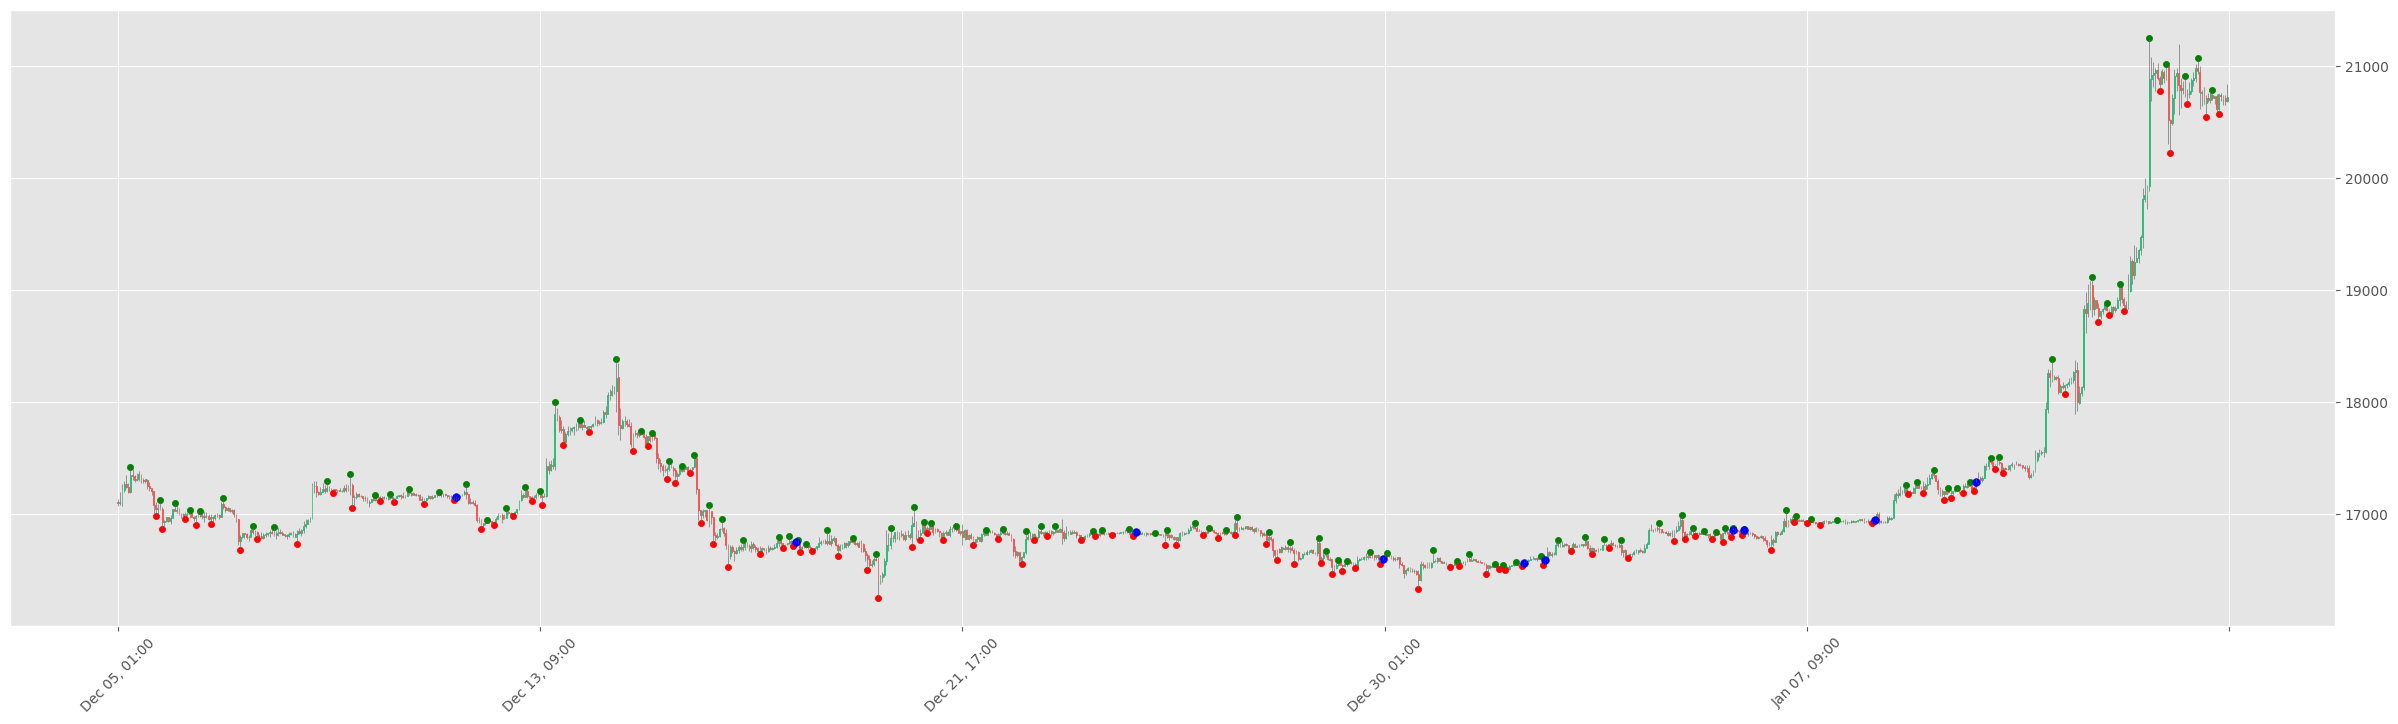

In [2]:
ttype = 'buy'
low_bound = 0
high_bound = 1000

# get H&S pattern
scatter_rsi_points = list()
pattern = SignalFactory().factory('Pattern', ttype, configs)

high_max = pattern.get_high_max(df)
low_min = pattern.get_low_min(df)
avg_gap = (df['high'] - df['low']).mean()
gmax, gmin = pattern.shrink_max_min(df, high_max.index, low_min.index)
    
# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.swing(df, min_max_idxs, min_max_vals, avg_gap)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find ascending/descending triangle

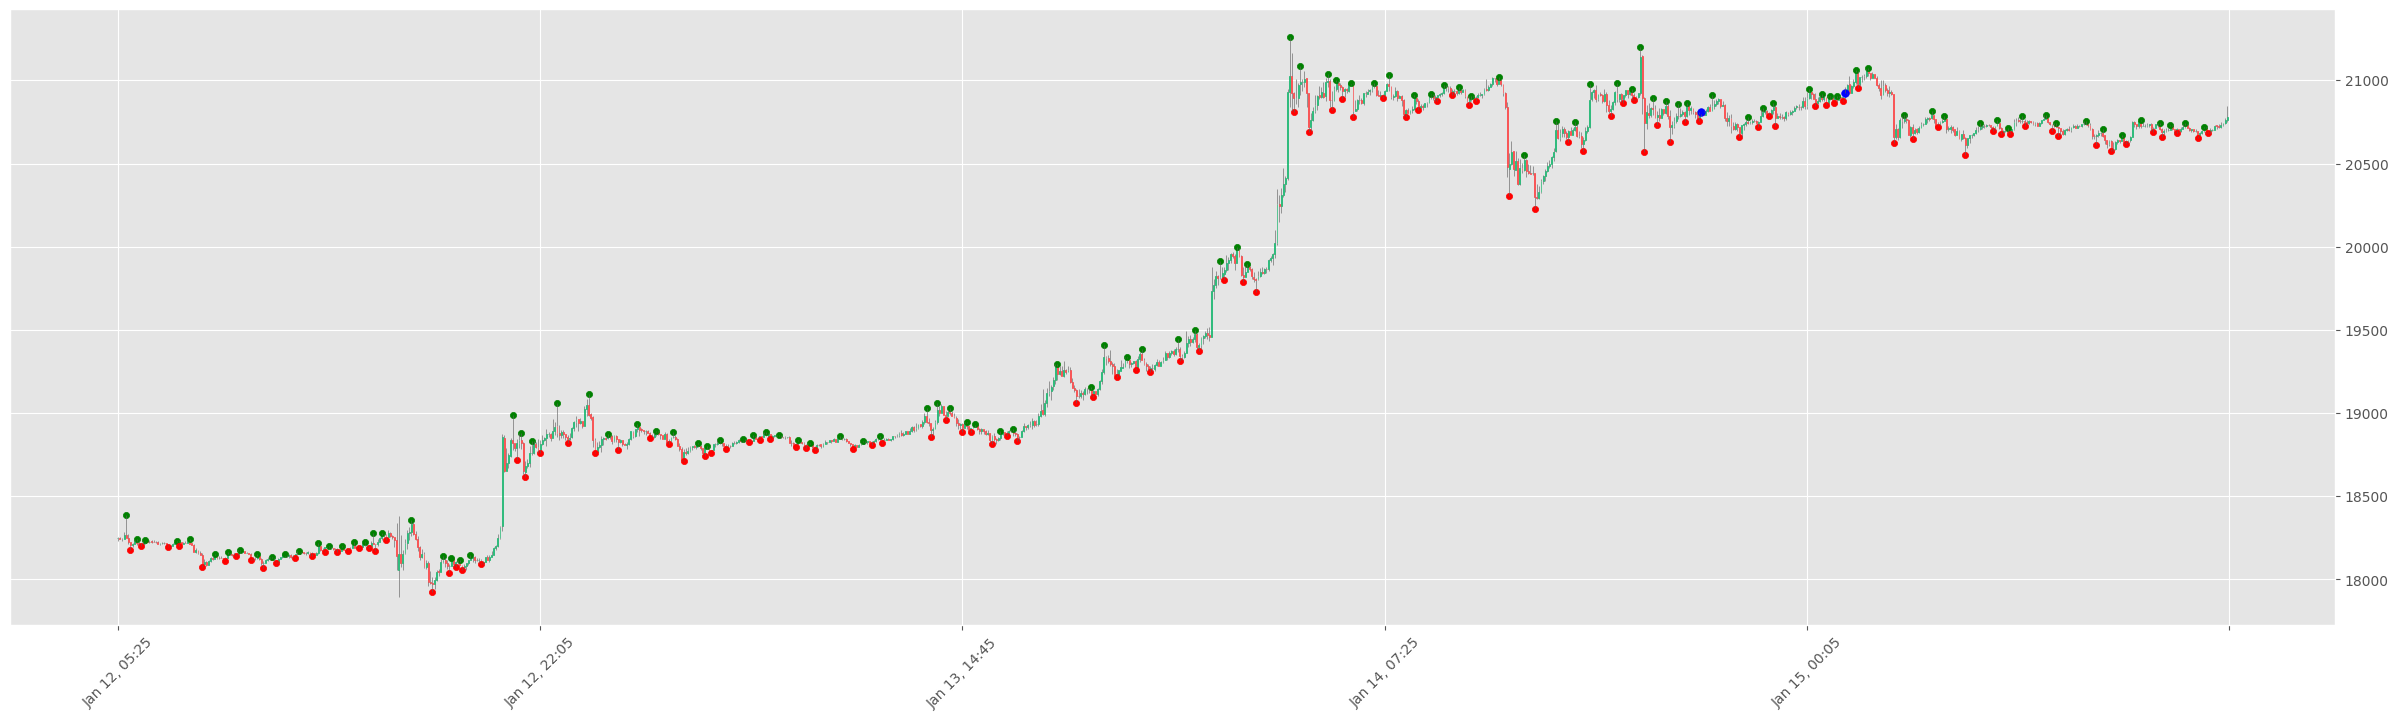

In [13]:
ttype = 'buy'
low_bound = 0
high_bound = 1000

# get H&S pattern
scatter_rsi_points = list()
pattern = SignalFactory().factory('Pattern', ttype, configs)

high_max = pattern.get_high_max(df)
low_min = pattern.get_low_min(df)
avg_gap = (df['high'] - df['low']).mean()
gmax, gmin = pattern.shrink_max_min(df, high_max.index, low_min.index)
    
# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.triangle(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find Head & Shoulders pattern

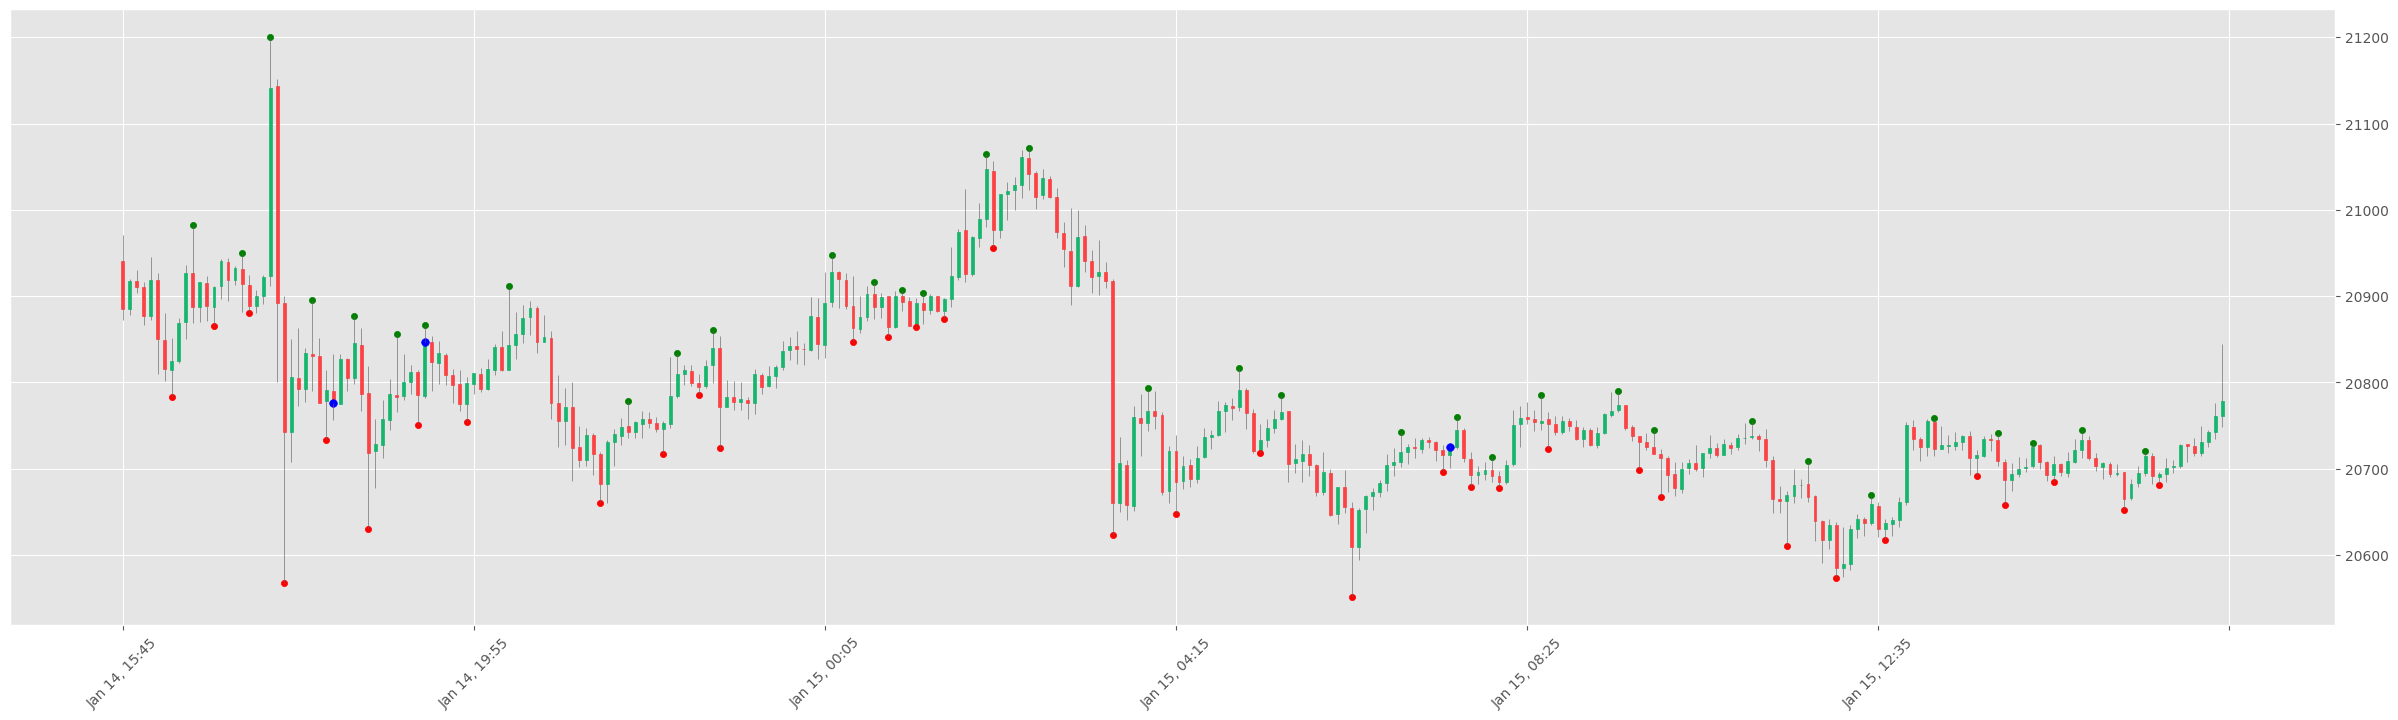

In [3]:
ttype = 'buy'
low_bound = 700
high_bound = 1000

# get H&S pattern
scatter_rsi_points = list()
pattern = SignalFactory().factory('Pattern', ttype, configs)

high_max = pattern.get_high_max(df)
low_min = pattern.get_low_min(df)
avg_gap = (df['high'] - df['low']).mean()
gmax, gmin = pattern.shrink_max_min(df, high_max.index, low_min.index)
    
# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.head_and_shoulders(df, min_max_idxs, min_max_vals, avg_gap)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find HLH/LHL

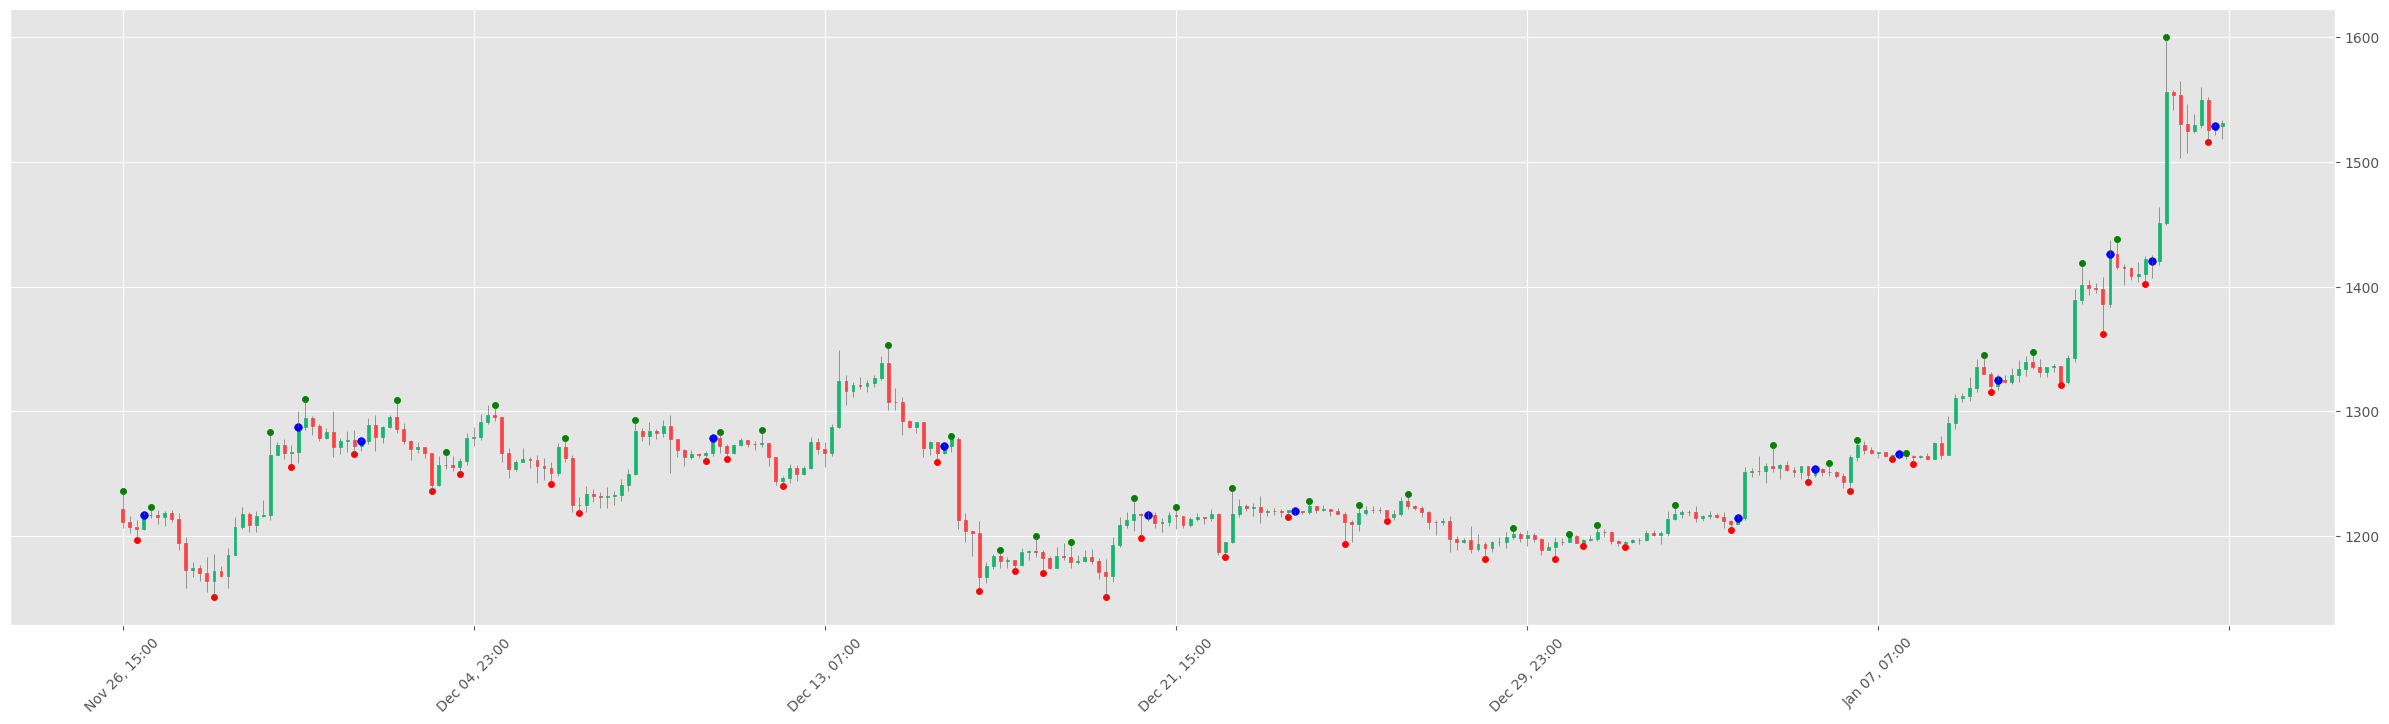

In [3]:
ttype = 'buy'
low_bound = 700
high_bound = 1000

# get H&S pattern
scatter_rsi_points = list()
pattern = SignalFactory().factory('Pattern', ttype, configs)

high_max = pattern.get_high_max(df)
low_min = pattern.get_low_min(df)
avg_gap = (df['high'] - df['low']).mean()
gmax, gmin = pattern.shrink_max_min(df, high_max.index, low_min.index)
    
# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.hlh_lhl(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find DT/DB

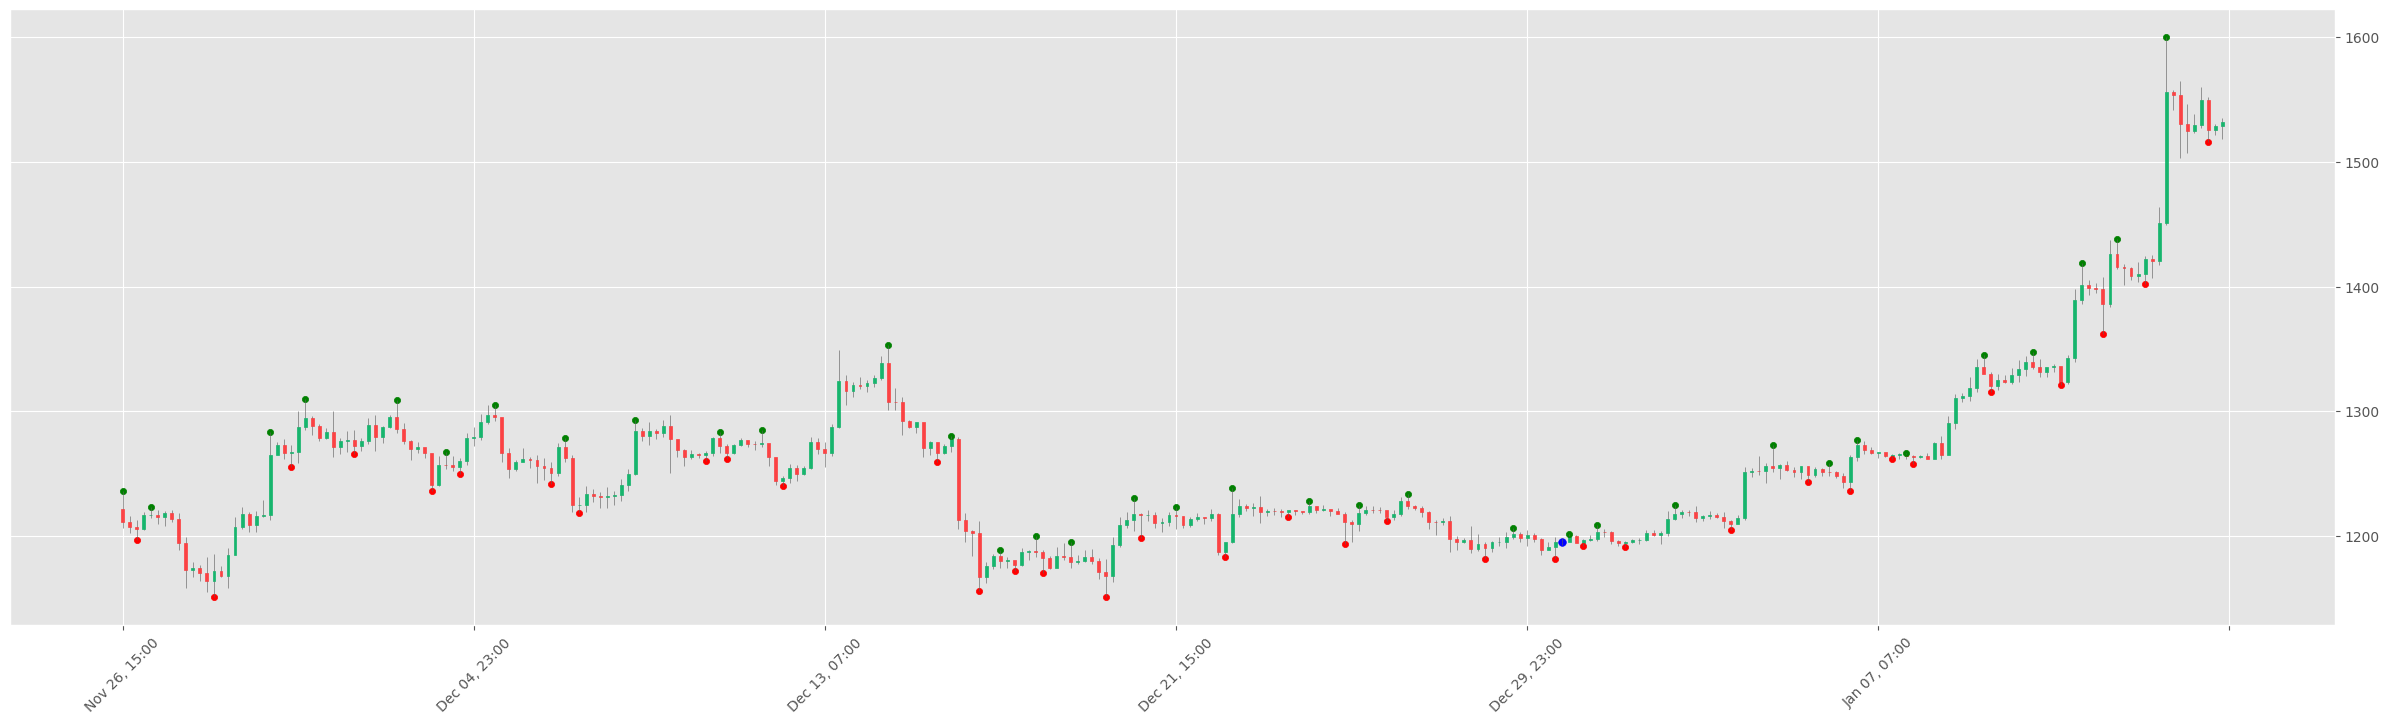

In [3]:
ttype = 'buy'
low_bound = 700
high_bound = 1000

# get H&S pattern
scatter_rsi_points = list()
pattern = SignalFactory().factory('Pattern', ttype, configs)

high_max = pattern.get_high_max(df)
low_min = pattern.get_low_min(df)
avg_gap = (df['high'] - df['low']).mean()
gmax, gmin = pattern.shrink_max_min(df, high_max.index, low_min.index)
    
# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.dt_db(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Add Pivot Points Trend

In [4]:
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt

def add_center(df):
    df['center'] = (df['high'] + df['low']) / 2
    for idx, row in df.iterrows():
        if idx > 0:
            if df.loc[idx, 'pvt_high'] == df.loc[idx-1, 'pvt_high']:
                df.loc[idx, 'center'] = (df.loc[idx-1, 'center'] * 2 + row['pvt_high'])/3
            elif df.loc[idx, 'pvt_low'] == df.loc[idx-1, 'pvt_low']:
                df.loc[idx, 'center'] = (df.loc[idx-1, 'center'] * 2 + row['pvt_low'])/3
            else:
                df.loc[idx, 'center'] = df.loc[idx-1, 'center']
    return df

def add_up_down(df, factor):
    df['up'] = df['center'] - factor * df['atr']
    df['down'] = df['center'] + factor * df['atr']
    return df

def add_trend_up_down(df):
    for idx, row in df.iterrows():
        if idx == 0:
            df.loc[idx,'trend_up'] = df.loc[idx, 'up']
            df.loc[idx,'trend_down'] = df.loc[idx, 'down']
        else:
            if df.loc[idx-1, 'close'] > df.loc[idx-1, 'trend_up']:
                df.loc[idx, 'trend_up'] = max(df.loc[idx, 'up'], df.loc[idx-1, 'trend_up'])
            else:
                df.loc[idx, 'trend_up'] = df.loc[idx, 'up']
            
            if df.loc[idx-1, 'close'] < df.loc[idx-1, 'trend_down']:
                df.loc[idx, 'trend_down'] = min(df.loc[idx, 'down'], df.loc[idx-1, 'trend_down'])
            else:
                df.loc[idx, 'trend_down'] = df.loc[idx, 'down']
    return df

factor = 3
pp_period = 2
# add pivot points
df['pvt_high'] = df['high'].shift(-pp_period).rolling(pp_period).max()
df['pvt_low'] = df['low'].shift(-pp_period).rolling(pp_period).min()
# add center and trend lines
df = add_center(df)
df = add_up_down(df, factor)
df = add_trend_up_down(df)
df.drop(['pvt_high', 'pvt_low', 'up', 'down'], axis=1, inplace=True)

# Find trade points

406.2500000000002


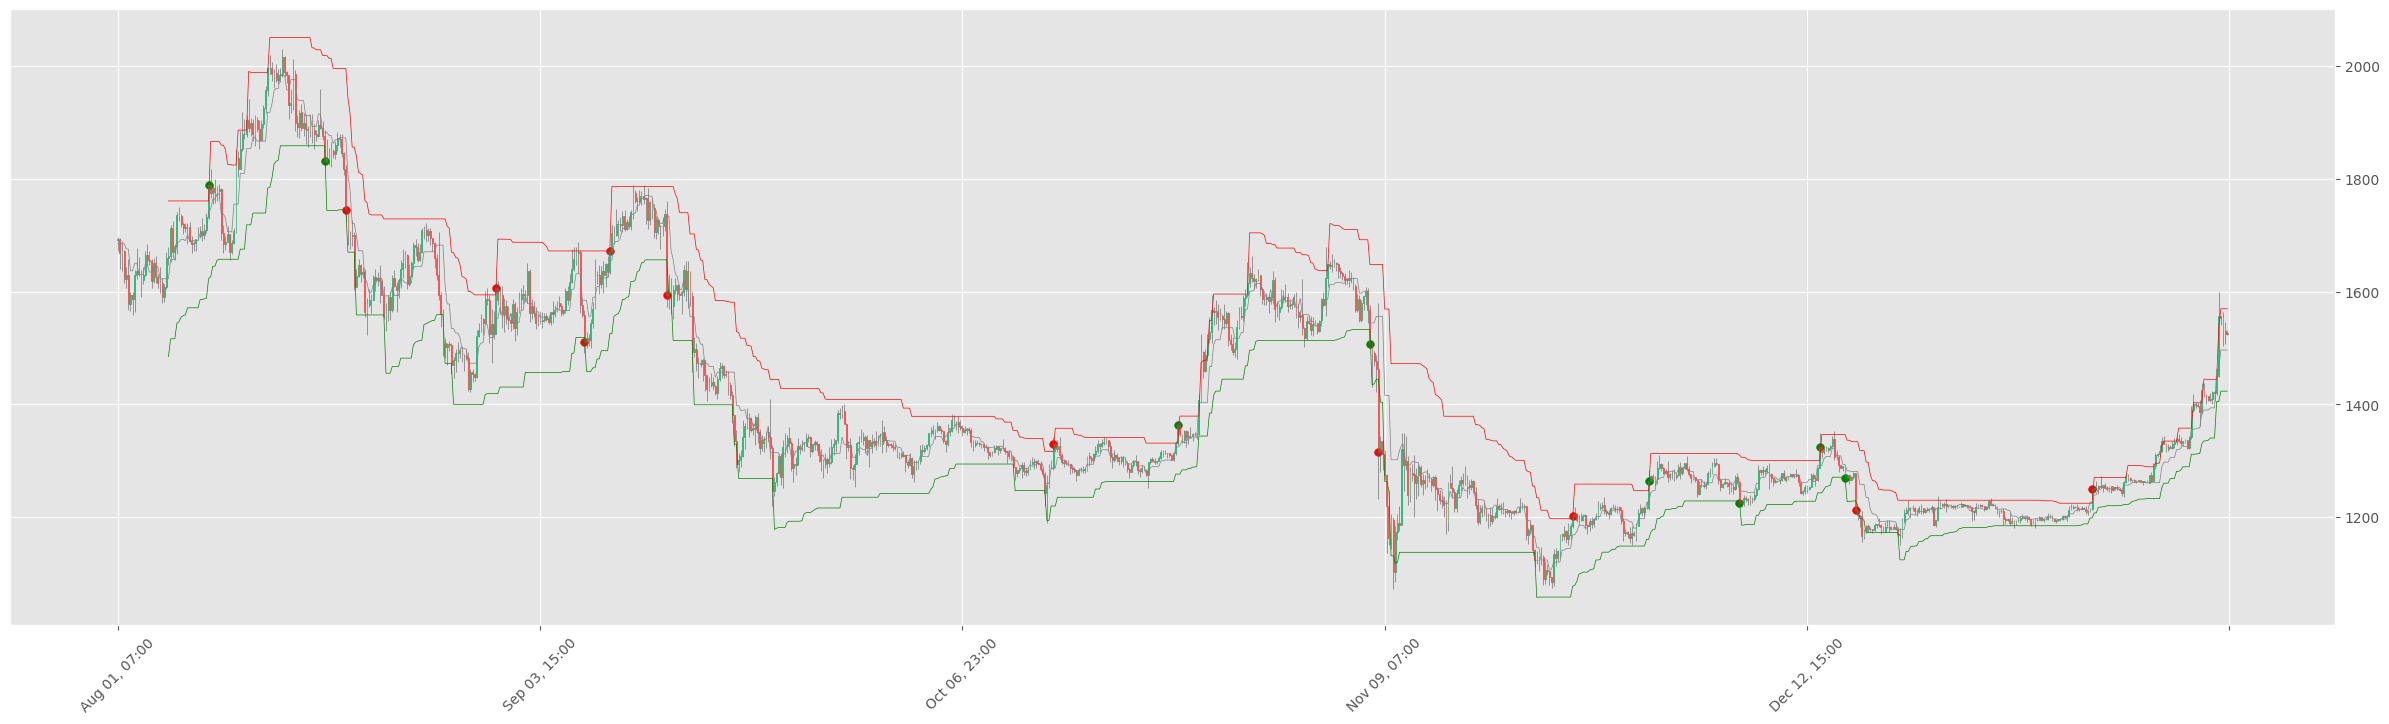

In [5]:
tp = list()
cooldown = 0
cooldown_val = 1
trade_points = list()

for idx, row in df.iterrows():
    if idx > 0:
        if cooldown > 0:
            cooldown -= 1  
        elif df.loc[idx, 'close'] > df.loc[idx-1, 'trend_down']:
                if len(tp) == 0:
                    tp = [['Buy', idx, df.loc[idx, 'close'], df.loc[idx, 'time']]]
                elif tp[0][0] == 'Sell':
                    tp.append(['Sell', idx, df.loc[idx, 'close'], df.loc[idx, 'time']])
                    trade_points.append(tp.copy())
                    tp = list()
                    cooldown = cooldown_val
#                     tp = [['Buy', idx, df.loc[idx, 'close'], df.loc[idx, 'time']]]
        elif df.loc[idx, 'close'] < df.loc[idx-1, 'trend_up']:
                if len(tp) == 0:
                    tp = [['Sell', idx, df.loc[idx, 'close'], df.loc[idx, 'time']]]
                elif tp[0][0] == 'Buy':
                    tp.append(['Buy', idx, df.loc[idx, 'close'], df.loc[idx, 'time']])
                    trade_points.append(tp.copy())
                    tp = list()
                    cooldown = cooldown_val
#                     tp = [['Sell', idx, df.loc[idx, 'close'], df.loc[idx, 'time']]]
                    
# plot the result
low_bound = 0
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
m1 = mpf.make_addplot(df['trend_up'][low_bound:], panel=1, ax=ax,  width=0.5, color='green')
m2 = mpf.make_addplot(df['trend_down'][low_bound:], panel=1, ax=ax,  width=0.5, color='red')
m3 = mpf.make_addplot(df['center'][low_bound:], panel=1, ax=ax,  width=0.5, color='grey')
                    
result = 0
    
for tp in trade_points:
    if tp[0][0] == 'Buy':
        color = 'green'
        result += tp[1][2] - tp[0][2]
    else:
        color = 'red'
        result += tp[0][2] - tp[1][2]
        
    ax.scatter(tp[0][1], tp[0][2], s=30, color=color)
    ax.scatter(tp[1][1], tp[1][2], s=30, color=color)
    
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', 
         tz_localize=True, ax=ax, addplot=[m1, m2, m3])

print(result)

# Test higher_bound and low_bound methods for RSI indicator

This methods return True if at least two of three last indicator points are higher/lower than high/low bound for this indicator.

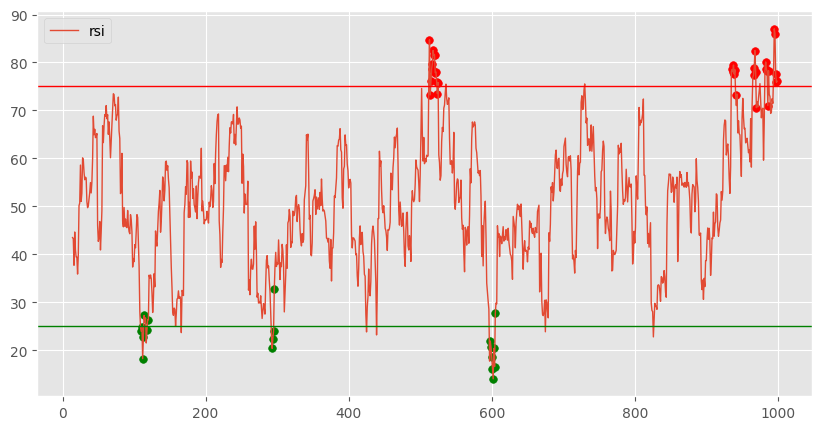

In [6]:
high_bound = 75
low_bound = 25
ttype = 'buy'

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot RSI
ax.plot(df.loc[:, 'rsi'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['rsi'])

# plot signal points
scatter_rsi_points = list()
rsi_sig = SignalFactory().factory('RSI', ttype, configs)

rsi_idxs =  rsi_sig.lower_bound(low_bound, df['rsi'], df['rsi'].shift(1), df['rsi'].shift(2))
scatter_buy_rsi_points = df.loc[rsi_idxs>0, 'rsi']
ax.scatter(scatter_buy_rsi_points.index, scatter_buy_rsi_points.values, s=30, color='green')

rsi_idxs =  rsi_sig.higher_bound(high_bound, df['rsi'], df['rsi'].shift(1), df['rsi'].shift(2))
scatter_sell_rsi_points = df.loc[rsi_idxs>0, 'rsi']
ax.scatter(scatter_sell_rsi_points.index, scatter_sell_rsi_points.values, s=30, color='red')
    
plt.show()

# Test up_direction and down_direction methods for STOCH indicator

This methods return True if indicator values increase/decrease.

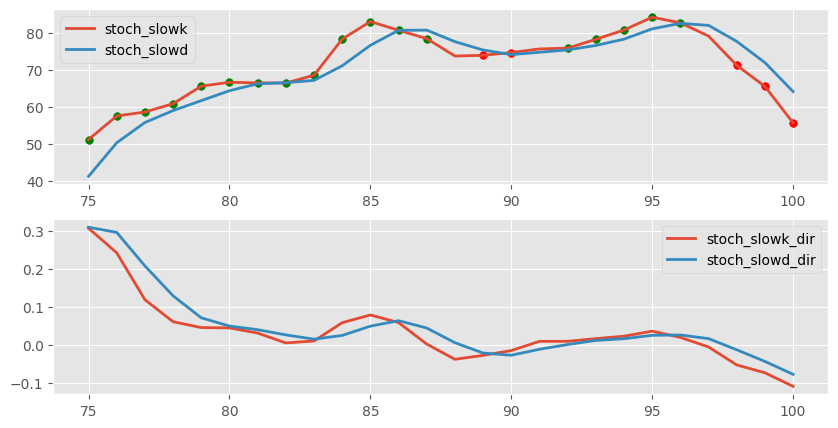

In [17]:
ttype = 'buy'

# subplots for STOCH
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot STOCH
ax1.plot(df.loc[75:100, 'stoch_slowk'], linewidth=2)
ax1.plot(df.loc[75:100, 'stoch_slowd'], linewidth=2)
ax2.plot(df.loc[75:100, 'stoch_slowk_dir'], linewidth=2)
ax2.plot(df.loc[75:100, 'stoch_slowd_dir'], linewidth=2)
leg = ax1.legend(['stoch_slowk', 'stoch_slowd'])
leg = ax2.legend(['stoch_slowk_dir', 'stoch_slowd_dir'])

# plot signal points
scatter_stoch_points_up = list()
scatter_stoch_points_down = list()

stoch_sig = SignalFactory().factory('STOCH', ttype, configs)

scatter_stoch_points_up = stoch_sig.up_direction(df.loc[75:100, 'stoch_slowk_dir']) & \
                          stoch_sig.up_direction(df.loc[75:100, 'stoch_slowd_dir'])
scatter_stoch_points_down = stoch_sig.down_direction(df.loc[75:100, 'stoch_slowk_dir']) & \
                            stoch_sig.down_direction(df.loc[75:100, 'stoch_slowd_dir'])

ax1.scatter(np.where(scatter_stoch_points_up)[0] + 75, df.loc[np.where(scatter_stoch_points_up)[0] + 75, 'stoch_slowk'], 
            s=30, color='green')
ax1.scatter(np.where(scatter_stoch_points_down)[0] + 75, df.loc[np.where(scatter_stoch_points_down)[0] + 75, 'stoch_slowk'], 
            s=30, color='red')
    
plt.show()

# Test crossed_lines method for STOCH indicator

This methods return True if two lines of indicator has crossed (for previous or pre-previous values).

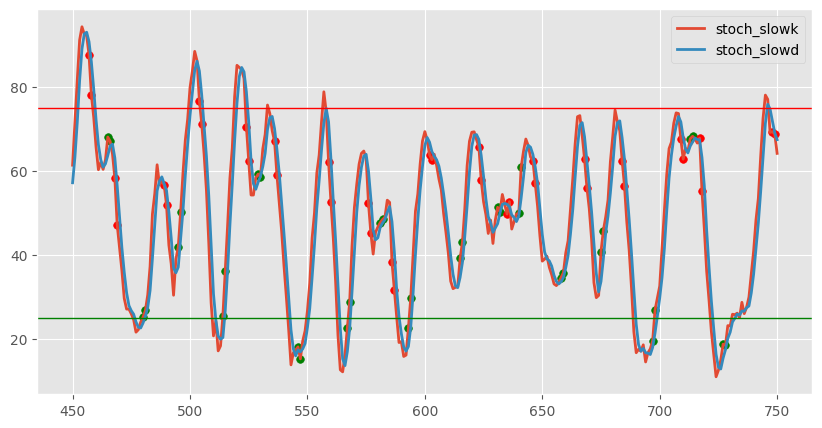

In [30]:
# subplots for RSI
ttype = 'sell'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
low_bound = 25
high_bound = 75
low_index = 450
high_index = 750
ax.plot(df.loc[low_index:high_index, 'stoch_slowk'], linewidth=2)
ax.plot(df.loc[low_index:high_index, 'stoch_slowd'], linewidth=2)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
stoch_sig = SignalFactory().factory('STOCH', ttype, configs)
scatter_stoch_points_up = stoch_sig.crossed_lines(False, df.loc[low_index:high_index, 'stoch_diff'], 
                                                  df.loc[low_index:high_index, 'stoch_diff'].shift(1), 
                                                  df.loc[low_index:high_index, 'stoch_diff'].shift(2)) 
scatter_stoch_points_down = stoch_sig.crossed_lines(True, df.loc[low_index:high_index, 'stoch_diff'], 
                                                    df.loc[low_index:high_index, 'stoch_diff'].shift(1), 
                                                    df.loc[low_index:high_index, 'stoch_diff'].shift(2)) 

ax.scatter(np.where(scatter_stoch_points_up)[0] + low_index, df.loc[np.where(scatter_stoch_points_up)[0] + low_index, 
                                                              'stoch_slowk'], s=30, color='green')
ax.scatter(np.where(scatter_stoch_points_down)[0] + low_index, df.loc[np.where(scatter_stoch_points_down)[0] + low_index, 
                                                                'stoch_slowk'], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for STOCH indicator

This methods return True if STOCH indicator is in overbuy/oversell zone, slowk and slowd lines has crossed and both changed their direction.

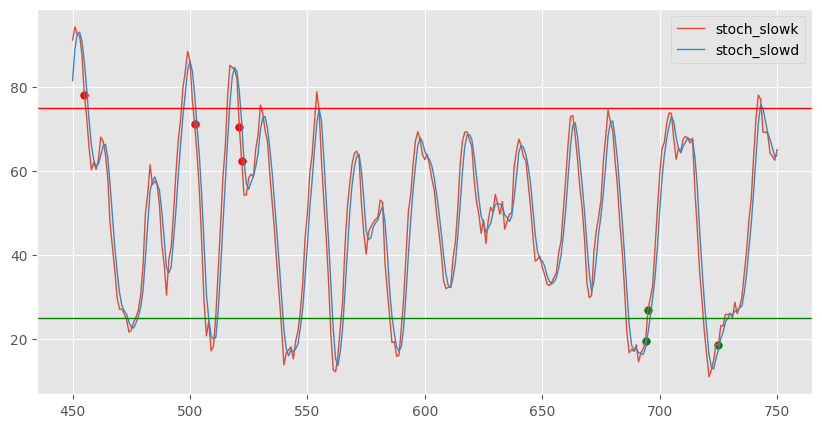

In [2]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
ttype = 'buy'
low_bound = 25
high_bound = 75
low_index = 450
high_index = 750
ax.plot(df.loc[low_index:high_index, 'stoch_slowk'], linewidth=1)
ax.plot(df.loc[low_index:high_index, 'stoch_slowd'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig_buy = SignalFactory().factory('STOCH', 'buy', configs)
stoch_sig_sell = SignalFactory().factory('STOCH', 'sell', configs)

fs_buy = stoch_sig_buy.find_signal(df)
fs_sell = stoch_sig_sell.find_signal(df)

for index in range(len(fs_buy)):
    if low_index < index < high_index:
            if fs_buy[index] == 1:
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            if fs_sell[index] == 1:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test crossed_lines method for MACD indicator

This methods return True if macd and macdsignal lines has crossed and both changed their direction.

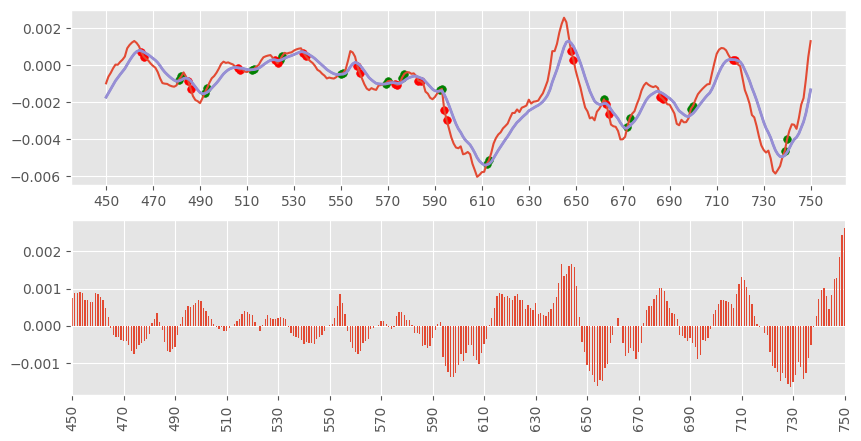

In [4]:
# subplots for MACD
ttype = 'sell'
low_index = 450
high_index = 750
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# plot MACD
df.loc[low_index:high_index, 'macd'].plot(ax=ax[0])
df.loc[low_index:high_index, 'macdsignal'].plot(ax=ax[0])
ax[0].plot(df.loc[low_index:high_index, 'macdsignal'], linewidth=2)
ax[0].set_xticks(np.arange(low_index, high_index+1, 20))
ax[0].set_xticklabels(np.arange(low_index, high_index+20, 20))

df.loc[low_index:high_index, 'macdhist'].plot.bar(ax=ax[1])
ax[1].set_xticks(ax[0].get_xticks()-low_index)

# plot signal points
macd_sig = SignalFactory().factory('MACD', ttype, configs)
scatter_stoch_points_up = macd_sig.crossed_lines(False, df.loc[low_index:high_index, 'macdhist'], 
                                                  df.loc[low_index:high_index, 'macdhist'].shift(1), 
                                                  df.loc[low_index:high_index, 'macdhist'].shift(2)) 
scatter_stoch_points_down = macd_sig.crossed_lines(True, df.loc[low_index:high_index, 'macdhist'], 
                                                    df.loc[low_index:high_index, 'macdhist'].shift(1), 
                                                    df.loc[low_index:high_index, 'macdhist'].shift(2)) 

ax[0].scatter(np.where(scatter_stoch_points_up)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_up)[0] + low_index, 'macd'], s=30, color='green')
ax[0].scatter(np.where(scatter_stoch_points_down)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_down)[0] + low_index, 'macd'], s=30, color='red')
    
plt.show()

# Test find_signal method for MACD indicator

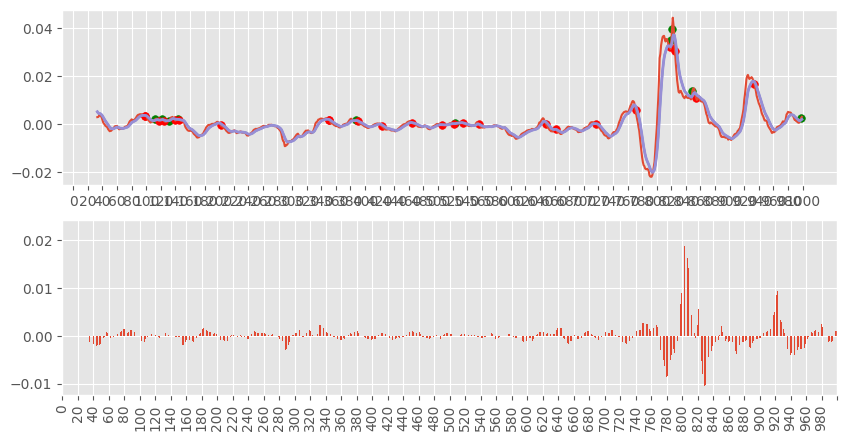

In [2]:
# subplots for MACD
ttype = 'sell'
low_index = 0
high_index = 1000
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# plot MACD
df.loc[low_index:high_index, 'macd'].plot(ax=ax[0])
df.loc[low_index:high_index, 'macdsignal'].plot(ax=ax[0])
ax[0].plot(df.loc[low_index:high_index, 'macdsignal'], linewidth=2)
ax[0].set_xticks(np.arange(low_index, high_index+1, 20))
ax[0].set_xticklabels(np.arange(low_index, high_index+20, 20))

df.loc[low_index:high_index, 'macdhist'].plot.bar(ax=ax[1])
ax[1].set_xticks(ax[0].get_xticks()-low_index)

# plot signal points
macd_sig_buy = SignalFactory().factory('MACD', 'buy', configs)
macd_sig_sell = SignalFactory().factory('MACD', 'sell', configs)
scatter_stoch_points_buy = macd_sig_buy.find_signal(df.loc[low_index:high_index]) 
scatter_stoch_points_sell = macd_sig_sell.find_signal(df.loc[low_index:high_index]) 

ax[0].scatter(np.where(scatter_stoch_points_buy)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_buy)[0] + low_index, 'macd'], s=30, color='green')
ax[0].scatter(np.where(scatter_stoch_points_sell)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_sell)[0] + low_index, 'macd'], s=30, color='red')
    
plt.show()

# Test find_lr method for LR indicator

This methods return True if price is near support level for the buy trade and near resistance level for the sell trade.

In [22]:
import pandas as pd
from talib import LINEARREG, LINEARREG_ANGLE, LINEARREG_SLOPE
timeperiod = 72

df_btc_1h = pd.read_pickle('test_ETHUSDT_1h.pkl')
df_btc_1h['linear_reg'] = LINEARREG(df_btc_1h['close'], timeperiod).reset_index(drop=True)
df_btc_1h['linear_reg_angle'] = LINEARREG_ANGLE(df_btc_1h['close'], timeperiod).reset_index(drop=True)

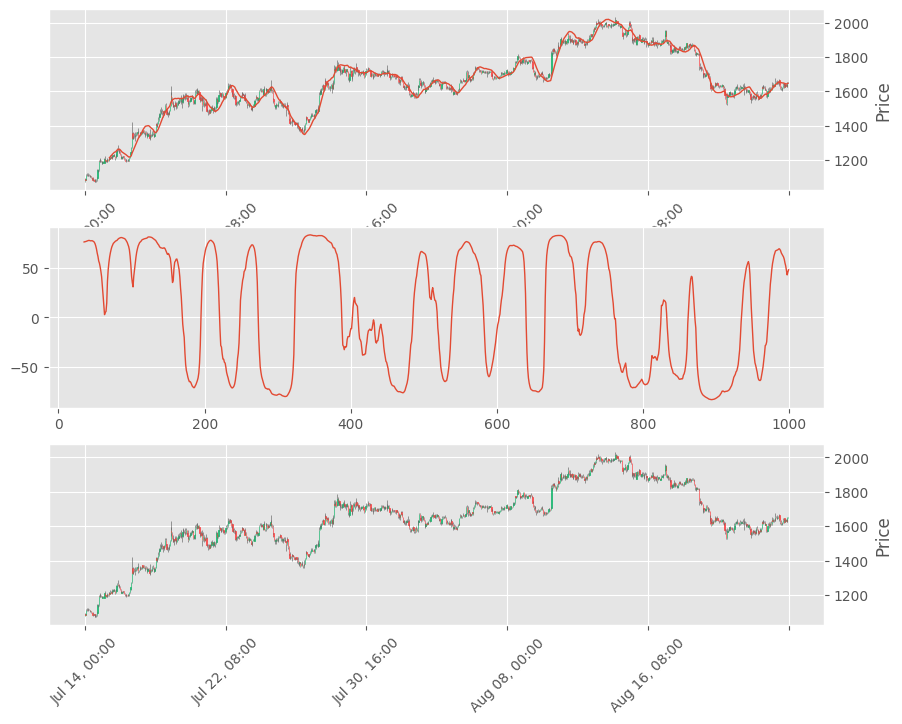

In [26]:
from talib import LINEARREG, LINEARREG_ANGLE, LINEARREG_SLOPE

low_bound = 0
high_bound = 1000
timeperiod = 36

sup_res_sig = SignalFactory().factory('SUP_RES', configs)
dfm = pd.read_pickle('test_ETHUSDT_1h.pkl')
dfh = pd.read_pickle('test_ETHUSDT_1h.pkl')

# subplots for RSI
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# plot candles
ohlch = dfh.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=axs[0], warn_too_much_data=10000, style='yahoo')

lr = LINEARREG(ohlch['close'], timeperiod).reset_index(drop=True)
lr_angle = LINEARREG_ANGLE(ohlch['close'], timeperiod).reset_index(drop=True)

axs[0].plot(lr, linewidth=1)
axs[1].plot(lr_angle, linewidth=1)

ohlcm = dfm.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlcm = ohlcm.set_index('time')
mpf.plot(ohlcm, type='candle', ax=axs[2], warn_too_much_data=10000, style='yahoo')
        
# plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI))

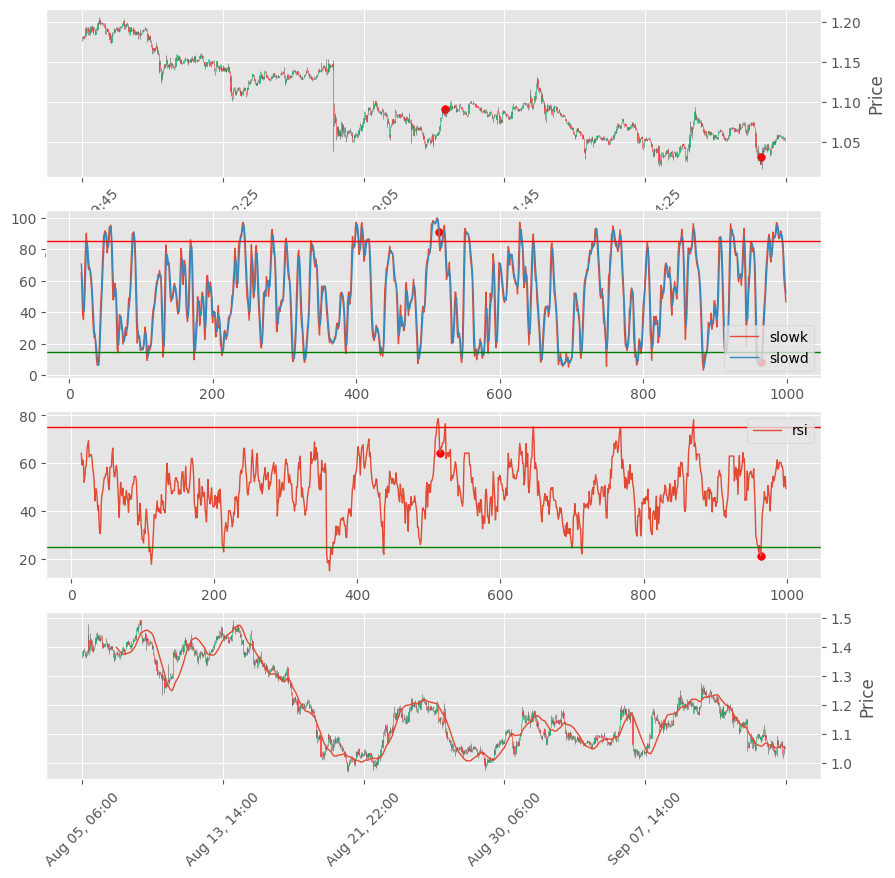

In [43]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
dfm = dfs['CRVUSDT']['5m']['data']
dfh = dfs['CRVUSDT']['1h']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(dfs, 'CRVUSDT', '5m', data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

# plot candles
ohlc = dfm.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(dfm.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(dfm.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(dfm.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

        
# plot higher timeframe candles + trend
ohlch = dfh[['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=ax4, warn_too_much_data=10000, style='yahoo')

timeperiod = 50
lr = LINEARREG(ohlch['close'], timeperiod).reset_index(drop=True)
lr_angle = LINEARREG_ANGLE(ohlch['close'], timeperiod).reset_index(drop=True)
ax4.plot(lr, linewidth=1)

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[2], dfm.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], dfm.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], dfm.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], dfm.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0], point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0], point[1], s=30, color='red')

        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI, SUP_RES))

In [7]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI', 'SUP_RES']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

TypeError: FindSignal.__init__() missing 1 required positional argument: 'configs'